<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [2]:
from tqdm import tqdm_notebook

In [3]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [4]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df_wine.loc[:, 'quality'] = (df_wine.loc[:, 'quality'] > 5).astype(int)

In [6]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [9]:
y.sum()

855

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [10]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

In [11]:
scores = []

for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=123)
    scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean())

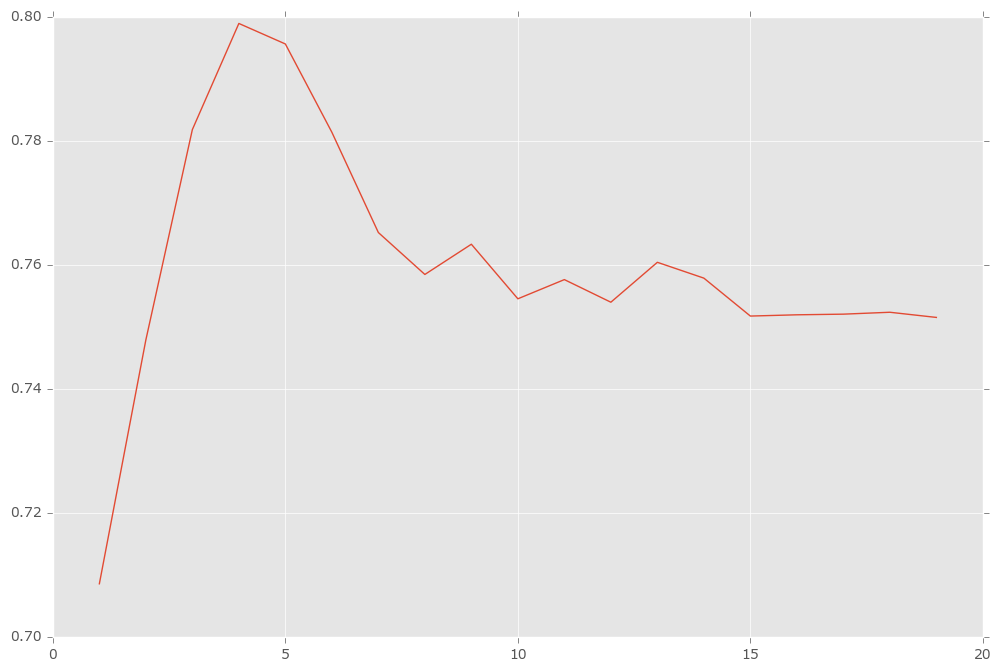

In [12]:
plt.plot(range(1,20), scores)

In [13]:
# Явный пик на глубине 4 наблядается для меры roc-auc
# Для меры качества accuracy выбрать оптимиальную глубину становится нетривиальным
# Если выбрать меру качества accuracy, то выбрать оптимальную глубину окажется не так просто.

# validation_curve возвращает меру качества как на тестовой части каждого из фолдов, так и на обучающей части

In [14]:
model = DecisionTreeClassifier(random_state=256)
train_scores, test_scores = validation_curve(model, X_train, y_train, 'max_depth',
                                             range(1, 20), n_jobs=-1, cv=5, scoring='roc_auc')

In [15]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

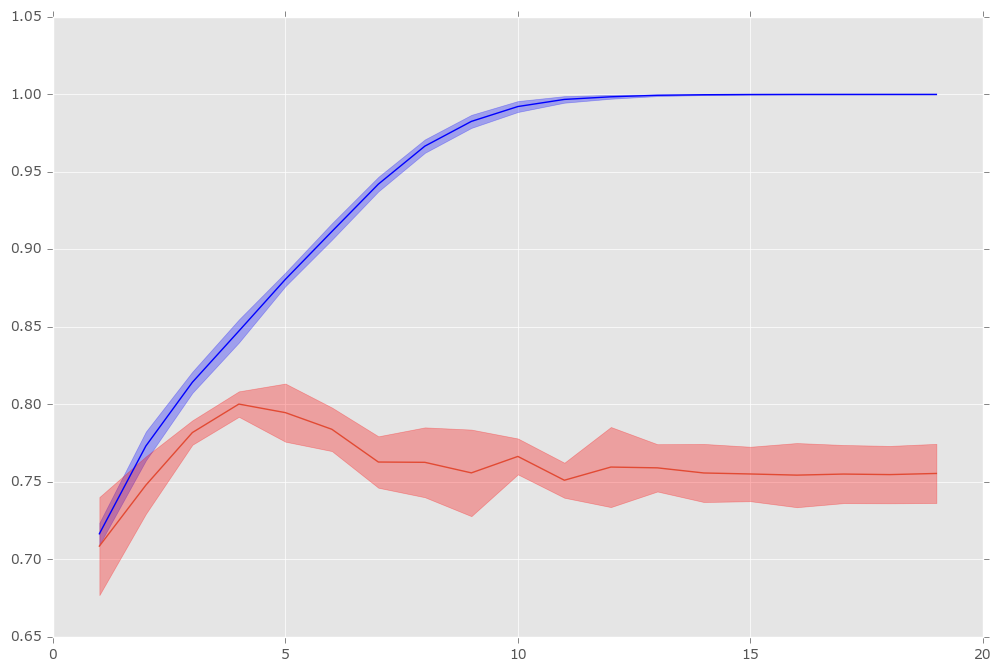

In [16]:
depth = range(1,20)
plt.plot(depth, train_mean, color='b')
plt.plot(depth, test_mean)

plt.fill_between(depth, train_mean - train_std, train_mean + train_std, color='b', alpha=0.3)
plt.fill_between(depth, test_mean - test_std, test_mean + test_std, color='r', alpha=0.3)

In [17]:
# Для roc-auc наблядаем тот же самый пик

# Для accuracy на той глубине, где accuracy был наибольший, ошибка на 
# на трейновой части минимальная, что говорит о сильном переобучении.

# Учитывая, что переобучение по accuracy на max_depth = 4 не такое сильное, а для roc-auc на этой глубине наблюдается 
# пик, то подходящим будет выбрать max_depth = 4

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [18]:
# Your Code Here
model = DecisionTreeClassifier(max_depth = 4)
model.fit(X_train, y_train)
imp = model.feature_importances_ 
imp

array([ 0.        ,  0.12647937,  0.        ,  0.        ,  0.        ,
        0.05226398,  0.05471579,  0.01356353,  0.01781177,  0.16057994,
        0.57458562])

Видно, что наибольший вклад вносят признаки volatile acidity, sulphate, alcohol

#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [21]:
X_train.shape[1]

11L

In [24]:
# Your Code Here
scores_first = []
scores_second = []
scores_third = []
for i in range(10, 110, 10):
    bag = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=5, random_state=254),
                        n_estimators=i,
                        max_samples=0.7,
                        max_features= 0.7,
                        bootstrap_features=True)
    
    rfr = RandomForestClassifier(n_estimators = i, max_depth = 5)
    dtc = DecisionTreeClassifier(max_depth=i // 10, random_state=254)
    scores_first.append(cross_val_score(bag, X_train, y_train, cv=5, scoring='roc_auc').mean())
    scores_second.append(cross_val_score(rfr, X_train, y_train, cv=5, scoring='roc_auc').mean())
    scores_third.append(cross_val_score(dtc, X_train, y_train, cv=5, scoring='roc_auc').mean())



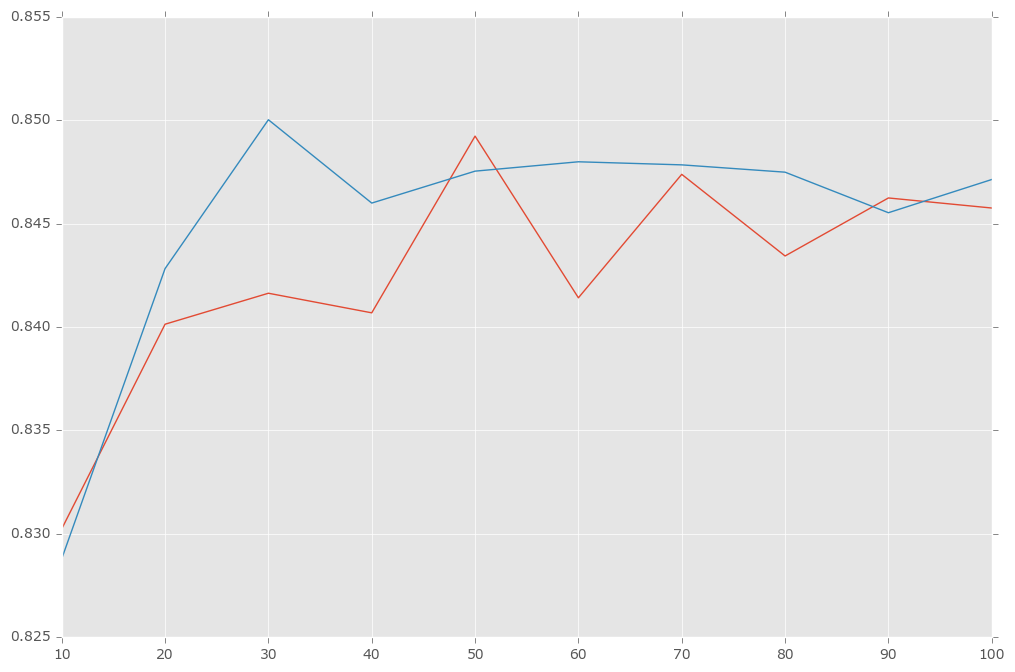

In [25]:
#Графики качества классификации при разных параметров и при разных алгоритмов
plt.plot(range(10, 110, 10), scores_1)
plt.plot(range(10, 110, 10), scores_2)


    

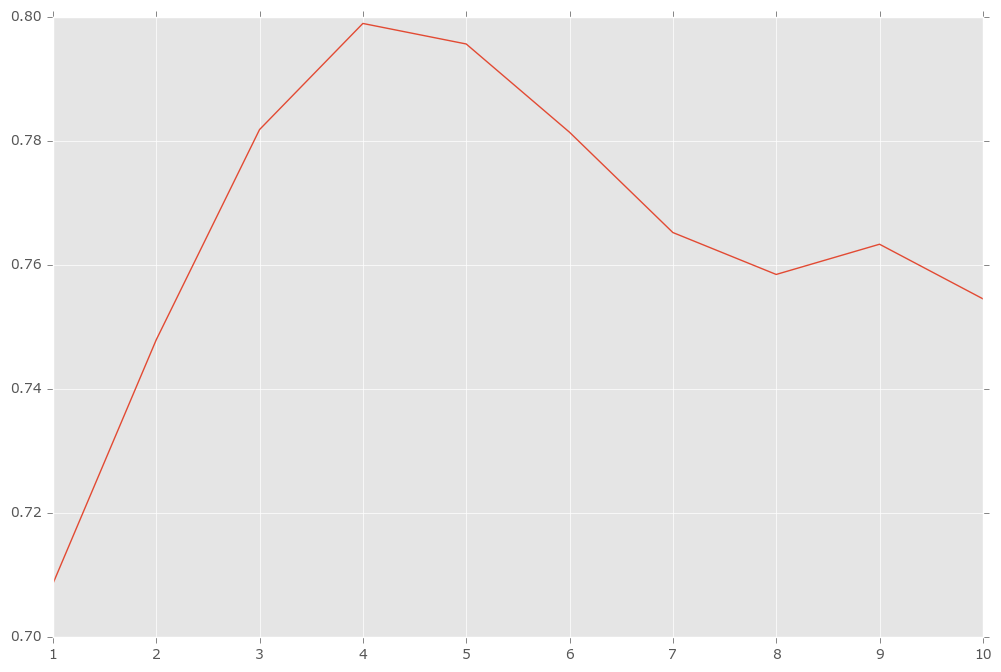

In [26]:
plt.plot(range(1, 11), scores_3)


####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [28]:
# Your Code Here
from sklearn.model_selection import GridSearchCV
rfr = RandomForestClassifier(random_state = 254)

param_grid = [
  {
        'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80], 
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
    }
 ]

param_grid
clf = GridSearchCV(rfr, param_grid, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=254,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [109]:
# Наиболее подходящие параметры: количество деревьев равно 70, а максимальная глубина дерева равна 55
clf.best_estimator_
best_parametrs = clf.best_estimator_.get_params()
best_parametrs
clf


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [139]:
score_rfr_train = []
model = RandomForestClassifier(max_depth = 16, n_estimators = 80)
score_rfr_train.append(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean())
score_rfr_train

[0.88931985294117644]

In [140]:
from sklearn.metrics import roc_auc_score, accuracy_score
model.fit(X_train, y_train)
y_predict = model.predict_proba(X_test)
roc_auc_score(y_test_bin, y_predict[:,1])


0.86985221674876856

Получается, что качество на контрольной выборке равно 0.87, а средняя на кросс-валидации 0.89